In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import sak
import sak.signal.wavelet
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
import glob
import wfdb
import json
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from sak.signal import StandardHeader

# Data loader to un-clutter code    
def load_data(filepath):
    dic = dict()
    with open(filepath) as f:
        text = list(f)
    for line in text:
        line = line.replace(' ','').replace('\n','').replace(',,','')
        if line[-1] == ',': line = line[:-1]
        head = line.split(',')[0]
        tail = line.split(',')[1:]
        if tail == ['']:
            tail = np.asarray([])
        else:
            tail = np.asarray(tail).astype(int)

        dic[head] = tail
    return dic


def trailonset(sig,on):
    on = on-sig[0]
    off = on-sig[0]+sig[-1]
    sig = sig+np.linspace(on,off,sig.size)
    
    return sig


In [42]:
basedir = '/home/guille/DADES/DADES/Delineator/ludb'
path_SVG = '/home/guille/Escritorio/LUDB/AS_IS/'
annotations = ['atr_{}'.format(lead.lower()) for lead in StandardHeader]

100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


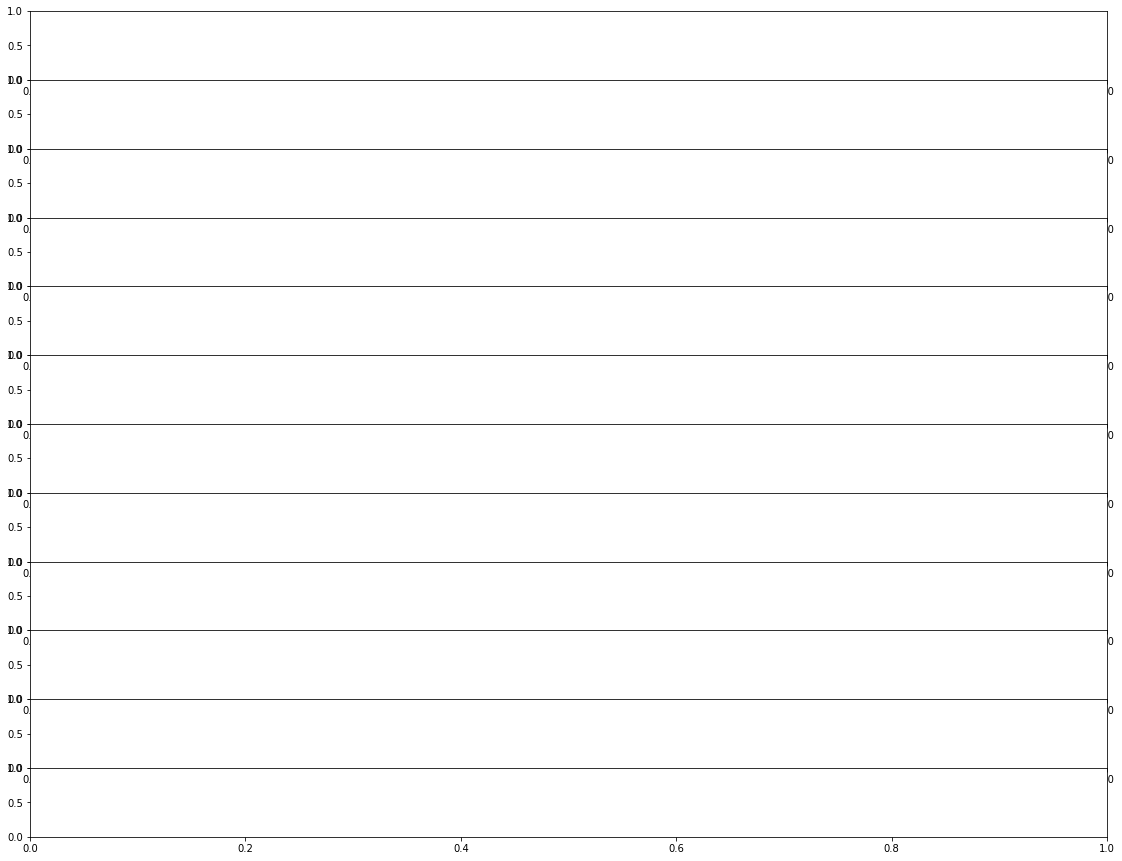

In [56]:
fig,ax = plt.subplots(nrows=12,figsize=(16,12))
pltargs = {'linewidth': 0, 'alpha': 0.15}

# For all files
for f in tqdm.tqdm(glob.glob(os.path.join(basedir,'*.dat'))):
    fname, ext = os.path.splitext(f)
    root, ludb_f = os.path.split(fname)
    
    # Load signal
    signal, header = wfdb.rdsamp(fname)
    channels = np.array(sak.map_upper(header['sig_name']))
    filt = sak.sort_as(channels, StandardHeader)
    channels = channels[filt]
    signal = signal[:,filt]
    sz,lds = signal.shape
    
    # Prepare mask
    mask = np.zeros((*signal.shape,3), dtype=bool)

    # Plot stuff
    [ax[i].plot(signal[:,i]) for i in range(len(StandardHeader))]
    [ax[i].set_xlim(0,sz) for i in range(len(StandardHeader))]
    
    # Iterate over annotations
    for i,ext in enumerate(annotations):
        mn, mx = ax[i].get_ylim()

        ann = wfdb.rdann(os.path.join(basedir,fname),ext)

        locP = np.where(np.array(ann.symbol) == 'p')[0]
        if len(locP) != 0:
            if locP[0]-1 < 0:
                locP = locP[1:]
            if locP[-1]+1 == len(ann.sample):
                locP = locP[:-1]
        locQRS = np.where(np.array(ann.symbol) == 'N')[0]
        if len(locQRS) != 0:
            if locQRS[0]-1 < 0:
                locQRS = locQRS[1:]
            if locQRS[-1]+1 == len(ann.sample):
                locQRS = locQRS[:-1]

        locT = np.where(np.array(ann.symbol) == 't')[0]
        if len(locT) != 0:
            if locT[0]-1 < 0:
                locT = locT[1:]
            if locT[-1]+1 == len(ann.sample):
                locT = locT[:-1]
                
        # Plot
        for j in range(locP.size):
            ax[i].axvspan(ann.sample[locP[j]-1], ann.sample[locP[j]+1], alpha=0.15, color='r')

        for j in range(locQRS.size):
            ax[i].axvspan(ann.sample[locQRS[j]-1], ann.sample[locQRS[j]+1], alpha=0.15, color='g')

        for j in range(locT.size):
            ax[i].axvspan(ann.sample[locT[j]-1], ann.sample[locT[j]+1], alpha=0.15, color='m')

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.00,wspace=0.05)
    fig.savefig(os.path.join(path_SVG,ludb_f+'.svg'))
    [ax[i].clear() for i in range(12)]
